# SMAI

## Assignment 3

### Question 4
### CNN and Autoencoders

In this part of the assignment, we are required to classify images from the MNIST dataset. Let us start by loading the model and then visualising the images.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
import numpy as np
from scipy.io import loadmat
from sklearn.metrics import classification_report, confusion_matrix
import random
import os
from PIL import Image
from sklearn.metrics import hamming_loss, accuracy_score
import wandb

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
batch_size = 100

train_dataset = torchvision.datasets.MNIST(root='./data', train = True, transform = transforms.ToTensor(), download = True)
test_dataset = torchvision.datasets.MNIST(root='./data', train = False, transform = transforms.ToTensor())

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)


Now let us see the distribution of all the labels across our training dataset.

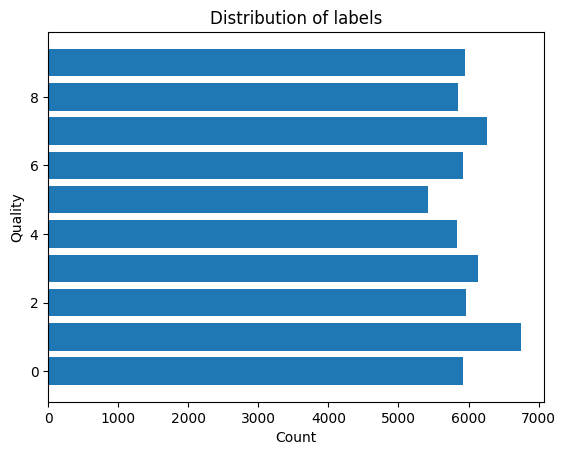

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [3]:
counter = Counter(train_dataset.targets.numpy())

count = list(counter.values())
labels = list(counter.keys())

plt.barh(labels, count)
plt.xlabel('Count')
plt.ylabel('Quality')
plt.title('Distribution of labels')
plt.show()
print(counter)

As we can see, there is very less class imbalance. Almost all the classes have equal number of samples. Hence there is no class imbalance. Let us visualise a couple images from every class to get an idea of the dataset.

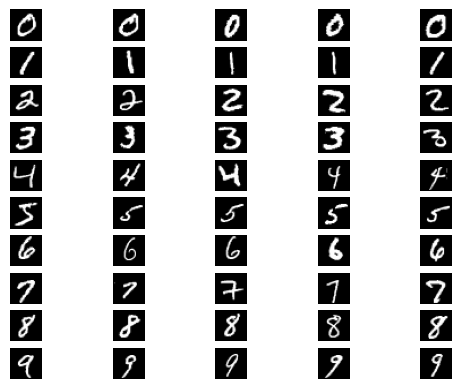

In [4]:
for i in range(10):
    indicies = np.where(train_dataset.targets.numpy() == i)[0][:5]
    for k, j in enumerate(indicies):
        plt.subplot(10, 5, 5*i + k + 1)
        plt.imshow(train_dataset.data[j], cmap='gray')
        plt.axis('off')

plt.show()

Now that we have a fair idea of our dataset, let us now begin making the model. Firstly, below is a function to visualise he feature maps of any given layer for a trained model.

In [5]:
def plot_feature_maps(model, layer_name, input_image):
    model.eval()
    
    feature_maps = None
    def hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output
    
    layer = dict(model.named_modules())[layer_name]
    hook_handle = layer.register_forward_hook(hook)
    
    with torch.no_grad():
        model(input_image)
    
    hook_handle.remove()

    feature_maps = feature_maps.cpu().numpy()
    
    num_feature_maps = feature_maps.shape[0]
    
    rows = num_feature_maps // 4
    cols = 4

    plt.figure(figsize=(12, 12))
    for i in range(num_feature_maps):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(feature_maps[i], cmap='viridis')
        plt.axis('off')
    
    plt.show()

Now let us make the CNN model with the specs given to us.

In [22]:
class CNN(nn.Module):

    def __init__(self, kernel_size = 3, stride = 1, dropout = 0.4):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size, stride = stride)
        self.conv2 = nn.Conv2d(6, 12, kernel_size, stride = stride)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.dropout = nn.Dropout(dropout)
        self.y = (28 - kernel_size + stride - 2*kernel_size*stride - 2*stride**2)//(4*stride**2) + 1
        self.fc1 = nn.Linear(self.y*12*self.y, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.y*self.y*12)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
def main1():
    wandb.init(project='SMAI3-3')

    config = wandb.config

    learning_rate = config['learning_rate']
    num_epochs = config['n_iterations']
    model = CNN(kernel_size = config['kernel_size'], stride = config['stride'], dropout = config['dropout'])

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

    n_total_steps = len(train_loader)
    for epoch in range(num_epochs):
        for i ,(images, labels) in enumerate(train_loader):

            output = model(images)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            data_to_log = {
                'Epoch' : epoch+1,
                'Train Loss' : loss,
            }

            wandb.log(data_to_log)

            if (i + 1) % 100 == 0:
                print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Loss : [{loss.item():.4f}]')

    
        
    

sweep_config = {
    'method':'random',
    'metric':{
        'name':'accuracy',
        'goal':'maximize'
    },
    'parameters':{
        'learning_rate':{
            'values':[0.0001, 0.001, 0.01, 0.1]
        },
        'n_iterations':{
            'values': [10, 20]
        },
        'kernel_size':{
            'values':[3, 4]
        },
        'stride':{
            'values':[1, 2, 3]
        },
        'dropout':{
            'values': [0.3, 0.4, 0.5, 0.6]
        }
    }
}


sweep_id = wandb.sweep(sweep=sweep_config, project = 'SMAI3-3')
wandb.agent(sweep_id, function=main1)

wandb.run.name = 'e2.GD.ce'

Create sweep with ID: qoxb865l
Sweep URL: https://wandb.ai/music-cognition/SMAI3-3/sweeps/qoxb865l


wandb: Agent Starting Run: nnoguxks with config:
wandb: 	dropout: 0.3
wandb: 	kernel_size: 4
wandb: 	learning_rate: 0.001
wandb: 	n_iterations: 20
wandb: 	stride: 2
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is saved locally in /home/vedansh/Desktop/SMAI assignments/Assignment3/wandb/run-20231023_220956-nnoguxks
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run fragrant-sweep-1
wandb: ⭐️ View project at https://wandb.ai/music-cognition/SMAI3-3
wandb: 🧹 View sweep at https://wandb.ai/music-cognition/SMAI3-3/sweeps/qoxb865l
wandb: 🚀 View run at https://wandb.ai/music-cognition/SMAI3-3/runs/nnoguxks


Epoch[1/20], step [100/600], Loss : [1.6325]
Epoch[1/20], step [200/600], Loss : [1.0126]
Epoch[1/20], step [300/600], Loss : [0.9789]
Epoch[1/20], step [400/600], Loss : [0.8486]
Epoch[1/20], step [500/600], Loss : [0.8523]
Epoch[1/20], step [600/600], Loss : [0.9008]
Epoch[2/20], step [100/600], Loss : [0.9387]
Epoch[2/20], step [200/600], Loss : [0.7745]
Epoch[2/20], step [300/600], Loss : [0.7784]
Epoch[2/20], step [400/600], Loss : [0.7282]
Epoch[2/20], step [500/600], Loss : [0.5876]
Epoch[2/20], step [600/600], Loss : [0.5494]
Epoch[3/20], step [100/600], Loss : [0.6202]
Epoch[3/20], step [200/600], Loss : [0.4545]
Epoch[3/20], step [300/600], Loss : [0.7949]
Epoch[3/20], step [400/600], Loss : [0.5219]
Epoch[3/20], step [500/600], Loss : [0.8233]
Epoch[3/20], step [600/600], Loss : [0.7600]
Epoch[4/20], step [100/600], Loss : [0.6532]
Epoch[4/20], step [200/600], Loss : [0.6367]
Epoch[4/20], step [300/600], Loss : [0.8352]
Epoch[4/20], step [400/600], Loss : [0.4487]
Epoch[4/20

wandb: Waiting for W&B process to finish... (success).


Epoch[20/20], step [600/600], Loss : [0.3910]


wandb: | 0.014 MB of 0.014 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb: Train Loss █▅▃▄▅▃▃▃▃▂▃▃▂▃▂▃▄▃▂▁▂▃▃▂▂▃▂▂▂▃▂▃▁▃▁▂▂▃▂▂
wandb: 
wandb: Run summary:
wandb:      Epoch 20
wandb: Train Loss 0.39096
wandb: 
wandb: 🚀 View run fragrant-sweep-1 at: https://wandb.ai/music-cognition/SMAI3-3/runs/nnoguxks
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_220956-nnoguxks/logs
wandb: Agent Starting Run: w7iihkj2 with config:
wandb: 	dropout: 0.5
wandb: 	kernel_size: 4
wandb: 	learning_rate: 0.0001
wandb: 	n_iterations: 20
wandb: 	stride: 1
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking 

Epoch[1/20], step [100/600], Loss : [2.2820]
Epoch[1/20], step [200/600], Loss : [2.0996]
Epoch[1/20], step [300/600], Loss : [1.3576]
Epoch[1/20], step [400/600], Loss : [0.9080]
Epoch[1/20], step [500/600], Loss : [1.1507]
Epoch[1/20], step [600/600], Loss : [0.6771]
Epoch[2/20], step [100/600], Loss : [0.6265]
Epoch[2/20], step [200/600], Loss : [0.5033]
Epoch[2/20], step [300/600], Loss : [0.6230]
Epoch[2/20], step [400/600], Loss : [0.7138]
Epoch[2/20], step [500/600], Loss : [0.5992]
Epoch[2/20], step [600/600], Loss : [0.5759]
Epoch[3/20], step [100/600], Loss : [0.4102]
Epoch[3/20], step [200/600], Loss : [0.4670]
Epoch[3/20], step [300/600], Loss : [0.5904]
Epoch[3/20], step [400/600], Loss : [0.4656]
Epoch[3/20], step [500/600], Loss : [0.4646]
Epoch[3/20], step [600/600], Loss : [0.4225]
Epoch[4/20], step [100/600], Loss : [0.3429]
Epoch[4/20], step [200/600], Loss : [0.5362]
Epoch[4/20], step [300/600], Loss : [0.3363]
Epoch[4/20], step [400/600], Loss : [0.3986]
Epoch[4/20

wandb: Waiting for W&B process to finish... (success).


Epoch[20/20], step [600/600], Loss : [0.0744]


wandb: - 0.014 MB of 0.014 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb: Train Loss █▄▄▂▂▂▂▂▂▂▁▂▂▁▂▂▁▁▂▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁
wandb: 
wandb: Run summary:
wandb:      Epoch 20
wandb: Train Loss 0.0744
wandb: 
wandb: 🚀 View run dulcet-sweep-2 at: https://wandb.ai/music-cognition/SMAI3-3/runs/w7iihkj2
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_221421-w7iihkj2/logs
wandb: Agent Starting Run: ib8oxdym with config:
wandb: 	dropout: 0.3
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.1
wandb: 	n_iterations: 20
wandb: 	stride: 2
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking run wi

Epoch[1/20], step [100/600], Loss : [2.3024]
Epoch[1/20], step [200/600], Loss : [2.3126]
Epoch[1/20], step [300/600], Loss : [2.3161]
Epoch[1/20], step [400/600], Loss : [2.3228]
Epoch[1/20], step [500/600], Loss : [2.2960]
Epoch[1/20], step [600/600], Loss : [2.3042]
Epoch[2/20], step [100/600], Loss : [2.2964]
Epoch[2/20], step [200/600], Loss : [2.3140]
Epoch[2/20], step [300/600], Loss : [2.3163]
Epoch[2/20], step [400/600], Loss : [2.3186]
Epoch[2/20], step [500/600], Loss : [2.3012]
Epoch[2/20], step [600/600], Loss : [2.3125]
Epoch[3/20], step [100/600], Loss : [2.3151]
Epoch[3/20], step [200/600], Loss : [2.3129]
Epoch[3/20], step [300/600], Loss : [2.3174]
Epoch[3/20], step [400/600], Loss : [2.3021]
Epoch[3/20], step [500/600], Loss : [2.3027]
Epoch[3/20], step [600/600], Loss : [2.3064]
Epoch[4/20], step [100/600], Loss : [2.3261]
Epoch[4/20], step [200/600], Loss : [2.2698]
Epoch[4/20], step [300/600], Loss : [2.2952]
Epoch[4/20], step [400/600], Loss : [2.2957]
Epoch[4/20

wandb: Waiting for W&B process to finish... (success).


Epoch[20/20], step [600/600], Loss : [2.3525]


wandb: | 0.002 MB of 0.014 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb: Train Loss ▃▃▅▂▃▄▄▄▃▆▄▃▃▄▄▃▆▆▄▃█▃▄▂▄▃▆▃▇▄▃▂▃▄▅▃▅▆▁▄
wandb: 
wandb: Run summary:
wandb:      Epoch 20
wandb: Train Loss 2.35247
wandb: 
wandb: 🚀 View run dark-sweep-3 at: https://wandb.ai/music-cognition/SMAI3-3/runs/ib8oxdym
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_221831-ib8oxdym/logs
wandb: Agent Starting Run: 2xglb2vp with config:
wandb: 	dropout: 0.5
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	n_iterations: 20
wandb: 	stride: 3
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking run 

Epoch[1/20], step [100/600], Loss : [1.4439]
Epoch[1/20], step [200/600], Loss : [1.2608]
Epoch[1/20], step [300/600], Loss : [1.3193]
Epoch[1/20], step [400/600], Loss : [1.2080]
Epoch[1/20], step [500/600], Loss : [1.1800]
Epoch[1/20], step [600/600], Loss : [1.4238]
Epoch[2/20], step [100/600], Loss : [1.3104]
Epoch[2/20], step [200/600], Loss : [1.1021]
Epoch[2/20], step [300/600], Loss : [1.1188]
Epoch[2/20], step [400/600], Loss : [1.1553]
Epoch[2/20], step [500/600], Loss : [1.0638]
Epoch[2/20], step [600/600], Loss : [0.9374]
Epoch[3/20], step [100/600], Loss : [1.1775]
Epoch[3/20], step [200/600], Loss : [1.3166]
Epoch[3/20], step [300/600], Loss : [1.0303]
Epoch[3/20], step [400/600], Loss : [1.0181]
Epoch[3/20], step [500/600], Loss : [1.0129]
Epoch[3/20], step [600/600], Loss : [0.9144]
Epoch[4/20], step [100/600], Loss : [1.0793]
Epoch[4/20], step [200/600], Loss : [0.8889]
Epoch[4/20], step [300/600], Loss : [0.8229]
Epoch[4/20], step [400/600], Loss : [0.8435]
Epoch[4/20

wandb: Waiting for W&B process to finish... (success).


Epoch[20/20], step [600/600], Loss : [0.7733]


wandb: | 0.014 MB of 0.014 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb: Train Loss █▇▂▃▃▆▅▅▄▃▄▃▄▅▃▂▁▅▂▂▃▂▁▂▃▂▂▂▂▃▁▁▂▃▃▁▁▃▂▃
wandb: 
wandb: Run summary:
wandb:      Epoch 20
wandb: Train Loss 0.77333
wandb: 
wandb: 🚀 View run polished-sweep-6 at: https://wandb.ai/music-cognition/SMAI3-3/runs/4y1krfkw
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_222313-4y1krfkw/logs
wandb: Agent Starting Run: 0gai538k with config:
wandb: 	dropout: 0.5
wandb: 	kernel_size: 4
wandb: 	learning_rate: 0.1
wandb: 	n_iterations: 10
wandb: 	stride: 1
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking run

Epoch[1/10], step [100/600], Loss : [2.3025]
Epoch[1/10], step [200/600], Loss : [2.3004]
Epoch[1/10], step [300/600], Loss : [2.2906]
Epoch[1/10], step [400/600], Loss : [2.3090]
Epoch[1/10], step [500/600], Loss : [2.2662]
Epoch[1/10], step [600/600], Loss : [2.3104]
Epoch[2/10], step [100/600], Loss : [2.3255]
Epoch[2/10], step [200/600], Loss : [2.3229]
Epoch[2/10], step [300/600], Loss : [2.3277]
Epoch[2/10], step [400/600], Loss : [2.2917]
Epoch[2/10], step [500/600], Loss : [2.3107]
Epoch[2/10], step [600/600], Loss : [2.2984]
Epoch[3/10], step [100/600], Loss : [2.3275]
Epoch[3/10], step [200/600], Loss : [2.3009]
Epoch[3/10], step [300/600], Loss : [2.3228]
Epoch[3/10], step [400/600], Loss : [2.3319]
Epoch[3/10], step [500/600], Loss : [2.3202]
Epoch[3/10], step [600/600], Loss : [2.3099]
Epoch[4/10], step [100/600], Loss : [2.3128]
Epoch[4/10], step [200/600], Loss : [2.3101]
Epoch[4/10], step [300/600], Loss : [2.3174]
Epoch[4/10], step [400/600], Loss : [2.3014]
Epoch[4/10

wandb: Waiting for W&B process to finish... (success).


Epoch[10/10], step [600/600], Loss : [2.3291]


wandb: / 0.005 MB of 0.011 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
wandb: Train Loss ▄▅▇▆▂▃▅▅▃▄▂▃▂▃█▅▄▂▄▆▁▃▃▅▃▄▅█▃▅▄▄▂▃▃▃▂▂▄▂
wandb: 
wandb: Run summary:
wandb:      Epoch 10
wandb: Train Loss 2.32912
wandb: 
wandb: 🚀 View run graceful-sweep-7 at: https://wandb.ai/music-cognition/SMAI3-3/runs/0gai538k
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_222602-0gai538k/logs
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wlxnf7dx with config:
wandb: 	dropout: 0.4
wandb: 	kernel_size: 4
wandb: 	learning_rate: 0.1
wandb: 	n_iterations: 20
wandb: 	stride: 2
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.in

Epoch[1/20], step [100/600], Loss : [2.3137]
Epoch[1/20], step [200/600], Loss : [2.3133]
Epoch[1/20], step [300/600], Loss : [2.2967]
Epoch[1/20], step [400/600], Loss : [2.2915]
Epoch[1/20], step [500/600], Loss : [2.2826]
Epoch[1/20], step [600/600], Loss : [2.2945]
Epoch[2/20], step [100/600], Loss : [2.3086]
Epoch[2/20], step [200/600], Loss : [2.3114]
Epoch[2/20], step [300/600], Loss : [2.2983]
Epoch[2/20], step [400/600], Loss : [2.3220]
Epoch[2/20], step [500/600], Loss : [2.2983]
Epoch[2/20], step [600/600], Loss : [2.3186]
Epoch[3/20], step [100/600], Loss : [2.3087]
Epoch[3/20], step [200/600], Loss : [2.3257]
Epoch[3/20], step [300/600], Loss : [2.3107]
Epoch[3/20], step [400/600], Loss : [2.3222]
Epoch[3/20], step [500/600], Loss : [2.2950]
Epoch[3/20], step [600/600], Loss : [2.3118]
Epoch[4/20], step [100/600], Loss : [2.3067]
Epoch[4/20], step [200/600], Loss : [2.3025]
Epoch[4/20], step [300/600], Loss : [2.2972]
Epoch[4/20], step [400/600], Loss : [2.3156]
Epoch[4/20

wandb: Waiting for W&B process to finish... (success).


Epoch[20/20], step [600/600], Loss : [2.3065]


wandb: / 0.014 MB of 0.014 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb: Train Loss ▄▅▅▇▅▆▂▁▄▃▆▄▃█▄▃▆▄▄▃▄▄▄▃▅▃▃▆▆▆▃▁▄▃▃▆▃▂▃▆
wandb: 
wandb: Run summary:
wandb:      Epoch 20
wandb: Train Loss 2.30649
wandb: 
wandb: 🚀 View run bumbling-sweep-8 at: https://wandb.ai/music-cognition/SMAI3-3/runs/wlxnf7dx
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_223017-wlxnf7dx/logs
wandb: Agent Starting Run: fvuzinii with config:
wandb: 	dropout: 0.6
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	n_iterations: 20
wandb: 	stride: 1
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking r

Epoch[1/20], step [100/600], Loss : [1.1123]
Epoch[1/20], step [200/600], Loss : [0.5468]
Epoch[1/20], step [300/600], Loss : [0.5573]
Epoch[1/20], step [400/600], Loss : [0.3603]
Epoch[1/20], step [500/600], Loss : [0.3446]
Epoch[1/20], step [600/600], Loss : [0.2295]
Epoch[2/20], step [100/600], Loss : [0.4662]
Epoch[2/20], step [200/600], Loss : [0.1869]
Epoch[2/20], step [300/600], Loss : [0.2207]
Epoch[2/20], step [400/600], Loss : [0.2395]
Epoch[2/20], step [500/600], Loss : [0.2165]
Epoch[2/20], step [600/600], Loss : [0.2601]
Epoch[3/20], step [100/600], Loss : [0.1985]
Epoch[3/20], step [200/600], Loss : [0.1639]
Epoch[3/20], step [300/600], Loss : [0.1986]
Epoch[3/20], step [400/600], Loss : [0.2023]
Epoch[3/20], step [500/600], Loss : [0.1967]
Epoch[3/20], step [600/600], Loss : [0.2469]
Epoch[4/20], step [100/600], Loss : [0.2454]
Epoch[4/20], step [200/600], Loss : [0.1403]
Epoch[4/20], step [300/600], Loss : [0.1523]
Epoch[4/20], step [400/600], Loss : [0.1527]
Epoch[4/20

wandb: Waiting for W&B process to finish... (success).


Epoch[20/20], step [600/600], Loss : [0.0530]


wandb: | 0.014 MB of 0.014 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
wandb: Train Loss █▆▄▄▃▂▂▃▂▁▂▂▃▂▂▂▂▁▂▁▂▂▃▂▂▂▂▂▂▂▁▂▁▂▃▁▂▁▁▁
wandb: 
wandb: Run summary:
wandb:      Epoch 20
wandb: Train Loss 0.05301
wandb: 
wandb: 🚀 View run glad-sweep-9 at: https://wandb.ai/music-cognition/SMAI3-3/runs/fvuzinii
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_223317-fvuzinii/logs
wandb: Agent Starting Run: z1vseb31 with config:
wandb: 	dropout: 0.6
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.1
wandb: 	n_iterations: 10
wandb: 	stride: 2
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking run wit

Epoch[1/10], step [100/600], Loss : [2.3044]
Epoch[1/10], step [200/600], Loss : [2.3259]
Epoch[1/10], step [300/600], Loss : [2.3011]
Epoch[1/10], step [400/600], Loss : [2.3019]
Epoch[1/10], step [500/600], Loss : [2.3170]
Epoch[1/10], step [600/600], Loss : [2.3100]
Epoch[2/10], step [100/600], Loss : [2.3004]
Epoch[2/10], step [200/600], Loss : [2.3094]
Epoch[2/10], step [300/600], Loss : [2.2985]
Epoch[2/10], step [400/600], Loss : [2.3004]
Epoch[2/10], step [500/600], Loss : [2.3072]
Epoch[2/10], step [600/600], Loss : [2.2877]
Epoch[3/10], step [100/600], Loss : [2.3052]
Epoch[3/10], step [200/600], Loss : [2.3115]
Epoch[3/10], step [300/600], Loss : [2.3058]
Epoch[3/10], step [400/600], Loss : [2.3079]
Epoch[3/10], step [500/600], Loss : [2.3092]
Epoch[3/10], step [600/600], Loss : [2.3058]
Epoch[4/10], step [100/600], Loss : [2.2947]
Epoch[4/10], step [200/600], Loss : [2.3082]
Epoch[4/10], step [300/600], Loss : [2.2965]
Epoch[4/10], step [400/600], Loss : [2.3264]
Epoch[4/10

wandb: Waiting for W&B process to finish... (success).


Epoch[10/10], step [600/600], Loss : [2.3062]


wandb: 
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
wandb: Train Loss ▆▅█▅▅▅▄▄▇▄▆▅█▄▄▆█▄▁▃▄▇▄▅▅█▅▅▅▄▅█▅▄▅▄▁▄▅▆
wandb: 
wandb: Run summary:
wandb:      Epoch 10
wandb: Train Loss 2.30624
wandb: 
wandb: 🚀 View run chocolate-sweep-10 at: https://wandb.ai/music-cognition/SMAI3-3/runs/z1vseb31
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_224109-z1vseb31/logs
wandb: Agent Starting Run: xmkdcjjp with config:
wandb: 	dropout: 0.6
wandb: 	kernel_size: 4
wandb: 	learning_rate: 0.0001
wandb: 	n_iterations: 10
wandb: 	stride: 2
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking run with wandb version 0.15.12
wandb: Run data i

Epoch[1/10], step [100/600], Loss : [2.2920]
Epoch[1/10], step [200/600], Loss : [2.2894]
Epoch[1/10], step [300/600], Loss : [2.2825]
Epoch[1/10], step [400/600], Loss : [2.2414]
Epoch[1/10], step [500/600], Loss : [2.1955]
Epoch[1/10], step [600/600], Loss : [2.0982]
Epoch[2/10], step [100/600], Loss : [1.9108]
Epoch[2/10], step [200/600], Loss : [1.8249]
Epoch[2/10], step [300/600], Loss : [1.8528]
Epoch[2/10], step [400/600], Loss : [1.7371]
Epoch[2/10], step [500/600], Loss : [1.7008]
Epoch[2/10], step [600/600], Loss : [1.4678]
Epoch[3/10], step [100/600], Loss : [1.5690]
Epoch[3/10], step [200/600], Loss : [1.5551]
Epoch[3/10], step [300/600], Loss : [1.5411]
Epoch[3/10], step [400/600], Loss : [1.4902]
Epoch[3/10], step [500/600], Loss : [1.3977]
Epoch[3/10], step [600/600], Loss : [1.4051]
Epoch[4/10], step [100/600], Loss : [1.2762]
Epoch[4/10], step [200/600], Loss : [1.4300]
Epoch[4/10], step [300/600], Loss : [1.4321]
Epoch[4/10], step [400/600], Loss : [1.4428]
Epoch[4/10

wandb: Waiting for W&B process to finish... (success).


Epoch[10/10], step [600/600], Loss : [1.1263]


wandb: / 0.011 MB of 0.011 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
wandb: Train Loss ███▇▆▅▄▄▄▃▃▃▃▃▄▃▂▄▂▃▃▃▂▃▄▂▂▂▁▃▂▂▃▂▁▂▂▂▁▂
wandb: 
wandb: Run summary:
wandb:      Epoch 10
wandb: Train Loss 1.12628
wandb: 
wandb: 🚀 View run clean-sweep-11 at: https://wandb.ai/music-cognition/SMAI3-3/runs/xmkdcjjp
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_224332-xmkdcjjp/logs
wandb: Agent Starting Run: ckc91rmx with config:
wandb: 	dropout: 0.5
wandb: 	kernel_size: 4
wandb: 	learning_rate: 0.001
wandb: 	n_iterations: 10
wandb: 	stride: 2
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking run

Epoch[1/10], step [100/600], Loss : [1.9025]
Epoch[1/10], step [200/600], Loss : [1.5624]
Epoch[1/10], step [300/600], Loss : [1.3739]
Epoch[1/10], step [400/600], Loss : [1.4152]
Epoch[1/10], step [500/600], Loss : [1.2329]
Epoch[1/10], step [600/600], Loss : [1.3310]
Epoch[2/10], step [100/600], Loss : [1.1994]
Epoch[2/10], step [200/600], Loss : [0.9068]
Epoch[2/10], step [300/600], Loss : [1.0947]
Epoch[2/10], step [400/600], Loss : [1.0974]
Epoch[2/10], step [500/600], Loss : [1.1480]
Epoch[2/10], step [600/600], Loss : [0.9790]
Epoch[3/10], step [100/600], Loss : [1.0651]
Epoch[3/10], step [200/600], Loss : [1.1592]
Epoch[3/10], step [300/600], Loss : [0.9035]
Epoch[3/10], step [400/600], Loss : [1.2311]
Epoch[3/10], step [500/600], Loss : [1.0736]
Epoch[3/10], step [600/600], Loss : [0.8859]
Epoch[4/10], step [100/600], Loss : [0.8686]
Epoch[4/10], step [200/600], Loss : [0.8594]
Epoch[4/10], step [300/600], Loss : [0.7673]
Epoch[4/10], step [400/600], Loss : [0.9531]
Epoch[4/10

wandb: Waiting for W&B process to finish... (success).


Epoch[10/10], step [600/600], Loss : [0.6532]


wandb: | 0.002 MB of 0.011 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
wandb: Train Loss █▅▃▃▄▃▄▃▃▃▂▃▂▁▂▃▃▃▂▁▂▂▁▂▂▂▁▂▃▁▂▁▂▁▁▁▁▂▂▁
wandb: 
wandb: Run summary:
wandb:      Epoch 10
wandb: Train Loss 0.65323
wandb: 
wandb: 🚀 View run eager-sweep-12 at: https://wandb.ai/music-cognition/SMAI3-3/runs/ckc91rmx
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_224513-ckc91rmx/logs
wandb: Agent Starting Run: y4l3y911 with config:
wandb: 	dropout: 0.6
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.0001
wandb: 	n_iterations: 10
wandb: 	stride: 2
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking ru

Epoch[1/10], step [100/600], Loss : [2.3030]
Epoch[1/10], step [200/600], Loss : [2.2794]
Epoch[1/10], step [300/600], Loss : [2.2573]
Epoch[1/10], step [400/600], Loss : [2.2073]
Epoch[1/10], step [500/600], Loss : [2.1573]
Epoch[1/10], step [600/600], Loss : [2.0219]
Epoch[2/10], step [100/600], Loss : [1.9872]
Epoch[2/10], step [200/600], Loss : [2.0492]
Epoch[2/10], step [300/600], Loss : [1.9203]
Epoch[2/10], step [400/600], Loss : [1.8629]
Epoch[2/10], step [500/600], Loss : [1.7987]
Epoch[2/10], step [600/600], Loss : [1.9018]
Epoch[3/10], step [100/600], Loss : [1.7893]
Epoch[3/10], step [200/600], Loss : [1.7238]
Epoch[3/10], step [300/600], Loss : [1.8589]
Epoch[3/10], step [400/600], Loss : [1.7821]
Epoch[3/10], step [500/600], Loss : [1.7612]
Epoch[3/10], step [600/600], Loss : [1.5130]
Epoch[4/10], step [100/600], Loss : [1.6970]
Epoch[4/10], step [200/600], Loss : [1.8210]
Epoch[4/10], step [300/600], Loss : [1.6388]
Epoch[4/10], step [400/600], Loss : [1.5713]
Epoch[4/10

wandb: Waiting for W&B process to finish... (success).


Epoch[10/10], step [600/600], Loss : [1.8143]


wandb: 
wandb: Run history:
wandb:      Epoch ▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
wandb: Train Loss ███▇▆▆▆▄▄▄▄▄▃▃▂▄▃▃▃▃▃▂▃▃▃▂▂▂▂▃▂▂▂▂▂▁▃▁▂▁
wandb: 
wandb: Run summary:
wandb:      Epoch 10
wandb: Train Loss 1.8143
wandb: 
wandb: 🚀 View run splendid-sweep-13 at: https://wandb.ai/music-cognition/SMAI3-3/runs/y4l3y911
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_224742-y4l3y911/logs
wandb: Agent Starting Run: lu0u87bz with config:
wandb: 	dropout: 0.6
wandb: 	kernel_size: 3
wandb: 	learning_rate: 0.001
wandb: 	n_iterations: 10
wandb: 	stride: 2
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: Tracking run with wandb version 0.15.12
wandb: Run data is s

Epoch[1/10], step [100/600], Loss : [2.0806]


wandb: Ctrl + C detected. Stopping sweep.
wandb: Waiting for W&B process to finish... (failed 1). Press Control-C to abort syncing.
wandb: | 0.002 MB of 0.009 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:      Epoch ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: Train Loss ███████████▇▇▇▇▇▆▆▅▆▅▅▅▄▃▃▂▅▄▂▁▂▂▁▁▃▂▁▁▁
wandb: 
wandb: Run summary:
wandb:      Epoch 1
wandb: Train Loss 1.76922
wandb: 
wandb: 🚀 View run ruby-sweep-14 at: https://wandb.ai/music-cognition/SMAI3-3/runs/lu0u87bz
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20231023_225042-lu0u87bz/logs


Now that out model is ready, we can start to implement the model with Adam optimization and cross entropy loss.

In [23]:
learning_rate = 0.001
num_epochs = 40
model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i ,(images, labels) in enumerate(train_loader):

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Loss : [{loss.item():.4f}]')

Epoch[1/40], step [100/600], Loss : [0.6598]
Epoch[1/40], step [200/600], Loss : [0.2606]
Epoch[1/40], step [300/600], Loss : [0.2772]
Epoch[1/40], step [400/600], Loss : [0.3212]
Epoch[1/40], step [500/600], Loss : [0.2068]


KeyboardInterrupt: 

In [ ]:
# Plotting the feature maps after the convolution layers.
images, labels = next(iter(train_loader))
indicies = np.where(labels == 1)[0]
layer_name = 'conv2'

for j in indicies:
    plot_feature_maps(model, layer_name, images[j])

Above is the feature maps for all images of '1' in my first batch of training samples. As we can see, it is clearly learning the pattern and the shape of the number 1 which shows how effectively the feature map works.

Now let us test our model on the test dataset.

In [16]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    predictions = torch.empty(1,)
    true_values = torch.empty(1,)

    for images, labels in test_loader:
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        predictions = torch.cat((predictions, predicted))
        true_values = torch.cat((true_values, labels))

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if(label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct/n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i]/n_class_samples[i]
        print(f'Accuracy of class {i}: {acc} %')

    print()
    print('CLASSIFICATION REPORT OF THE TEST SET')
    print(classification_report(predictions[1:], true_values[1:]))

    print()
    print('CONFUSION MATRIC OF THE TEST SET')
    print(confusion_matrix(predictions[1:], true_values[1:]))

Accuracy of the network: 98.53 %
Accuracy of class 0: 99.6938775510204 %
Accuracy of class 1: 99.03083700440529 %
Accuracy of class 2: 99.6124031007752 %
Accuracy of class 3: 99.4059405940594 %
Accuracy of class 4: 96.94501018329939 %
Accuracy of class 5: 98.20627802690584 %
Accuracy of class 6: 97.49478079331942 %
Accuracy of class 7: 98.34630350194553 %
Accuracy of class 8: 97.43326488706366 %
Accuracy of class 9: 98.90981169474728 %

CLASSIFICATION REPORT OF THE TEST SET
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       997
         1.0       0.99      0.99      0.99      1131
         2.0       1.00      0.98      0.99      1046
         3.0       0.99      0.97      0.98      1034
         4.0       0.97      1.00      0.98       955
         5.0       0.98      0.99      0.98       889
         6.0       0.97      1.00      0.99       938
         7.0       0.98      0.99      0.99      1021
         8.0       0.97      0.99 

### Autoencoders

Now we will implement the autoencoder, let us begin with loading the noisy MNIST dataset.

In [17]:
noisy_data = loadmat('mnist-with-awgn.mat')
train_x = torch.tensor(np.reshape(noisy_data['train_x'], (-1, 1,28, 28)))
train_y = torch.tensor(np.argmax(noisy_data['train_y'], 1))

test_x = torch.tensor(np.reshape(noisy_data['test_x'], (-1, 1,28, 28)))
test_y = torch.tensor(np.argmax(noisy_data['test_y'], 1))

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)


Let us take a look at the distribution of labels in the dataset.

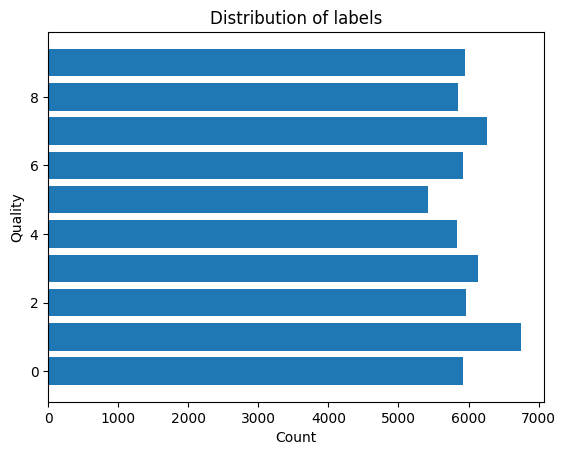

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [18]:
counter = Counter(train_y.numpy())

count = list(counter.values())
labels = list(counter.keys())

plt.barh(labels, count)
plt.xlabel('Count')
plt.ylabel('Quality')
plt.title('Distribution of labels')
plt.show()
print(counter)

Now let us visualise the different numbers from the noisy data.

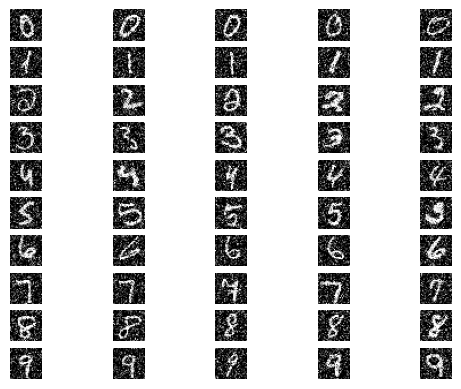

In [19]:
for i in range(10):
    indicies = np.where(train_y == i)[0][:5]
    for k, j in enumerate(indicies):
        plt.subplot(10, 5, 5*i + k + 1)
        plt.imshow(train_x[j][0], cmap='gray')
        plt.axis('off')

plt.show()

Now, we will train our previously made CNN model on this noisy dataset. 

In [20]:
learning_rate = 0.001
num_epochs = 40
model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i ,(images, labels) in enumerate(train_loader):

        output = model(images.float())
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Loss : [{loss.item():.4f}]')

Epoch[1/40], step [100/600], Loss : [0.4402]
Epoch[1/40], step [200/600], Loss : [0.2174]
Epoch[1/40], step [300/600], Loss : [0.3075]
Epoch[1/40], step [400/600], Loss : [0.2049]
Epoch[1/40], step [500/600], Loss : [0.0969]
Epoch[1/40], step [600/600], Loss : [0.2393]
Epoch[2/40], step [100/600], Loss : [0.1124]
Epoch[2/40], step [200/600], Loss : [0.0713]
Epoch[2/40], step [300/600], Loss : [0.2873]
Epoch[2/40], step [400/600], Loss : [0.0640]
Epoch[2/40], step [500/600], Loss : [0.1237]
Epoch[2/40], step [600/600], Loss : [0.1247]
Epoch[3/40], step [100/600], Loss : [0.1029]
Epoch[3/40], step [200/600], Loss : [0.0688]
Epoch[3/40], step [300/600], Loss : [0.0867]
Epoch[3/40], step [400/600], Loss : [0.0667]
Epoch[3/40], step [500/600], Loss : [0.0779]
Epoch[3/40], step [600/600], Loss : [0.0471]
Epoch[4/40], step [100/600], Loss : [0.0220]
Epoch[4/40], step [200/600], Loss : [0.1751]
Epoch[4/40], step [300/600], Loss : [0.0516]
Epoch[4/40], step [400/600], Loss : [0.1342]
Epoch[4/40

Now let us check its accuracy with the test data.

In [21]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    predictions = torch.empty(1,)
    true_values = torch.empty(1,)

    for images, labels in test_loader:
        outputs = model(images.float())

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        predictions = torch.cat((predictions, predicted))
        true_values = torch.cat((true_values, labels))

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if(label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct/n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i]/n_class_samples[i]
        print(f'Accuracy of class {i}: {acc} %')

    print()
    print('CLASSIFICATION REPORT OF THE TEST SET')
    print(classification_report(predictions[1:], true_values[1:]))

    print()
    print('CONFUSION MATRIC OF THE TEST SET')
    print(confusion_matrix(predictions[1:], true_values[1:]))

Accuracy of the network: 97.21 %
Accuracy of class 0: 98.87755102040816 %
Accuracy of class 1: 99.03083700440529 %
Accuracy of class 2: 98.06201550387597 %
Accuracy of class 3: 97.62376237623762 %
Accuracy of class 4: 98.57433808553971 %
Accuracy of class 5: 95.73991031390135 %
Accuracy of class 6: 98.32985386221294 %
Accuracy of class 7: 95.91439688715953 %
Accuracy of class 8: 97.43326488706366 %
Accuracy of class 9: 92.26957383548067 %

CLASSIFICATION REPORT OF THE TEST SET
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       986
         1.0       0.99      0.98      0.99      1146
         2.0       0.98      0.97      0.98      1039
         3.0       0.98      0.98      0.98      1009
         4.0       0.99      0.95      0.97      1014
         5.0       0.96      0.97      0.96       882
         6.0       0.98      0.98      0.98       960
         7.0       0.96      0.97      0.96      1016
         8.0       0.97      0.

Let us now make an autoencoder model so that it performs better than the current CNN model

In [22]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(64, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 1, 3, padding = 1)
        self.upsample = nn.Upsample(scale_factor=2, mode = 'bilinear', align_corners=False)

    def forward(self, x):
        x = self.upsample(F.relu(self.conv1(x)))
        x = self.upsample(F.relu(self.conv2(x)))
        return x

class CNNAutoencoder(nn.Module):
    
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Since we dont have the denoised versions of our noisy dataset, we will use the original MNIST dataset and apply noise to those images and attempt to denoise them.

In [23]:
train_dataset_noisy = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x + 0.3*torch.randn_like(x))]))
train_dataset_denoised = torchvision.datasets.MNIST(root='./data', train = True, transform = transforms.ToTensor(), download = True)

dataset_noise = torch.zeros(60000, 1, 28, 28)
dataset_denoise = torch.zeros(60000, 1, 28, 28)

for i in range(len(train_dataset)):
    dataset_noise[i] = torch.clamp(train_dataset_noisy[i][0], 0, 1)
    dataset_denoise[i] = train_dataset_denoised[i][0]

train_dataset = TensorDataset(dataset_noise, dataset_denoise)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Now let us look at some of the noisy-denoisy image pairs.

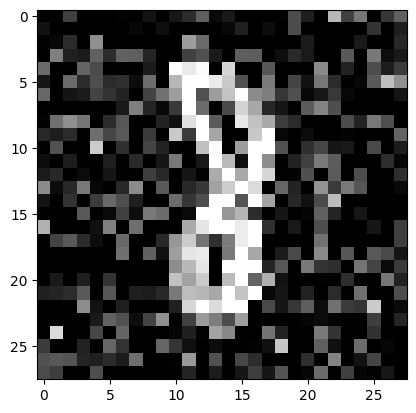

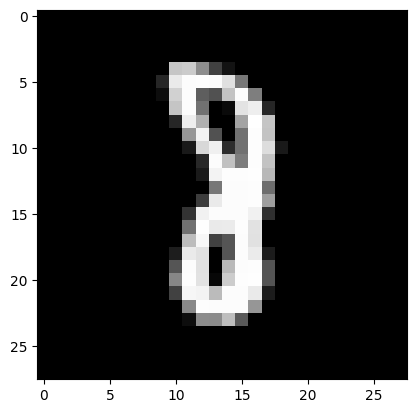

In [24]:
noise, denoise = next(iter(train_loader))
plt.imshow(noise[0][0], cmap='gray')
plt.figure()
plt.imshow(denoise[0][0], cmap='gray')

Now let us train our autoencoder model to denoise our image.

In [25]:
learning_rate = 0.001
num_epochs = 10

model = CNNAutoencoder()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i ,(noisy_image, denoisy_image) in enumerate(train_loader):

        output = model(noisy_image)
        loss = criterion(output, denoisy_image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Loss : [{loss.item():.4f}]')

Epoch[1/10], step [100/600], Loss : [0.0263]
Epoch[1/10], step [200/600], Loss : [0.0226]
Epoch[1/10], step [300/600], Loss : [0.0208]
Epoch[1/10], step [400/600], Loss : [0.0214]
Epoch[1/10], step [500/600], Loss : [0.0194]
Epoch[1/10], step [600/600], Loss : [0.0173]
Epoch[2/10], step [100/600], Loss : [0.0170]
Epoch[2/10], step [200/600], Loss : [0.0172]
Epoch[2/10], step [300/600], Loss : [0.0175]
Epoch[2/10], step [400/600], Loss : [0.0167]
Epoch[2/10], step [500/600], Loss : [0.0170]
Epoch[2/10], step [600/600], Loss : [0.0164]
Epoch[3/10], step [100/600], Loss : [0.0162]
Epoch[3/10], step [200/600], Loss : [0.0164]
Epoch[3/10], step [300/600], Loss : [0.0157]
Epoch[3/10], step [400/600], Loss : [0.0163]
Epoch[3/10], step [500/600], Loss : [0.0166]
Epoch[3/10], step [600/600], Loss : [0.0154]
Epoch[4/10], step [100/600], Loss : [0.0166]
Epoch[4/10], step [200/600], Loss : [0.0163]
Epoch[4/10], step [300/600], Loss : [0.0160]
Epoch[4/10], step [400/600], Loss : [0.0156]
Epoch[4/10

Now that we have an autoencoder capable of denoising images, we will proceed to denoising the noisy dataset given to us and train the CNN again to classify the images.

In [26]:
with torch.no_grad():
    train_x_denoised = model(train_x.float())
    test_x_denoised = model(test_x.float())

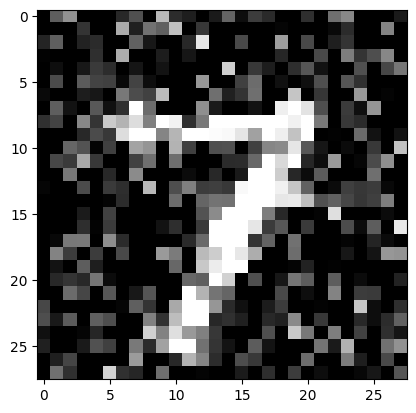

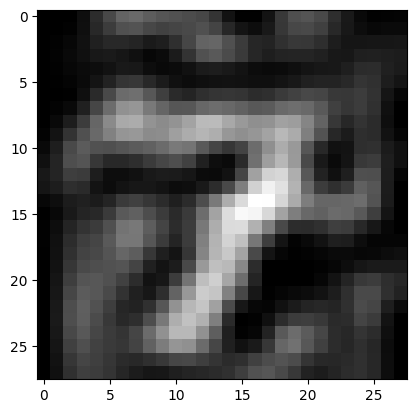

In [27]:
i = random.randint(0, 60000)
plt.imshow(train_x[i][0], cmap = 'gray')
plt.figure()
plt.imshow(train_x_denoised[i][0], cmap = 'gray')


Now that we have our denoised images, let us train the CNN moel to classify these images and see how the model does.

In [28]:
train_dataset = TensorDataset(train_x_denoised, train_y)
test_dataset = TensorDataset(test_x_denoised, test_y)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

In [29]:
learning_rate = 0.001
num_epochs = 40
model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i ,(images, labels) in enumerate(train_loader):

        output = model(images.float())
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Loss : [{loss.item():.4f}]')

Epoch[1/40], step [100/600], Loss : [0.2110]
Epoch[1/40], step [200/600], Loss : [0.2489]
Epoch[1/40], step [300/600], Loss : [0.3109]
Epoch[1/40], step [400/600], Loss : [0.2243]
Epoch[1/40], step [500/600], Loss : [0.1415]
Epoch[1/40], step [600/600], Loss : [0.2634]
Epoch[2/40], step [100/600], Loss : [0.0755]
Epoch[2/40], step [200/600], Loss : [0.1176]
Epoch[2/40], step [300/600], Loss : [0.1404]
Epoch[2/40], step [400/600], Loss : [0.1297]
Epoch[2/40], step [500/600], Loss : [0.1390]
Epoch[2/40], step [600/600], Loss : [0.3069]
Epoch[3/40], step [100/600], Loss : [0.0865]
Epoch[3/40], step [200/600], Loss : [0.2142]
Epoch[3/40], step [300/600], Loss : [0.1527]
Epoch[3/40], step [400/600], Loss : [0.1395]
Epoch[3/40], step [500/600], Loss : [0.0863]
Epoch[3/40], step [600/600], Loss : [0.2008]
Epoch[4/40], step [100/600], Loss : [0.2457]
Epoch[4/40], step [200/600], Loss : [0.0736]
Epoch[4/40], step [300/600], Loss : [0.0994]
Epoch[4/40], step [400/600], Loss : [0.0847]
Epoch[4/40

In [31]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    predictions = torch.empty(1,)
    true_values = torch.empty(1,)

    for images, labels in test_loader:
        outputs = model(images.float())

        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        predictions = torch.cat((predictions, predicted))
        true_values = torch.cat((true_values, labels))

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if(label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct/n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i]/n_class_samples[i]
        print(f'Accuracy of class {i}: {acc} %')

    print()
    print('CLASSIFICATION REPORT OF THE TEST SET')
    print(classification_report(predictions[1:], true_values[1:]))

    print()
    print('CONFUSION MATRIC OF THE TEST SET')
    print(confusion_matrix(predictions[1:], true_values[1:]))

Accuracy of the network: 96.46 %
Accuracy of class 0: 99.08163265306122 %
Accuracy of class 1: 98.6784140969163 %
Accuracy of class 2: 95.54263565891473 %
Accuracy of class 3: 96.83168316831683 %
Accuracy of class 4: 95.010183299389 %
Accuracy of class 5: 95.06726457399103 %
Accuracy of class 6: 96.65970772442589 %
Accuracy of class 7: 96.59533073929961 %
Accuracy of class 8: 95.68788501026694 %
Accuracy of class 9: 95.04459861248762 %

CLASSIFICATION REPORT OF THE TEST SET
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      1015
         1.0       0.99      0.98      0.98      1140
         2.0       0.96      0.98      0.97      1004
         3.0       0.97      0.95      0.96      1029
         4.0       0.95      0.97      0.96       958
         5.0       0.95      0.96      0.96       882
         6.0       0.97      0.98      0.97       943
         7.0       0.97      0.95      0.96      1040
         8.0       0.96      0.97 

### Question 5
### Some other variants

We have with us the double MNIST dataset, which contains the pictures of 2 digit numbers.

In [32]:
batch_size = 100
transform = transforms.Compose([transforms.ToTensor()])
dataset_path = 'double_mnist_seed_123_image_size_64_64/'
data = {'train' : [], 'test' : [], 'val' : []}
labels = {'train' : [], 'test' : [], 'val' : []}

for split in ['train', 'test', 'val']:
    split_path = os.path.join(dataset_path, split)
    class_folders = os.listdir(split_path)

    for folder in class_folders:
        class_path = os.path.join(split_path, folder)
        class_label = int(folder)

        image_files = os.listdir(class_path)

        digit1 = class_label // 10
        digit2 = class_label % 10

        label = np.zeros((10))
        label[digit1] = 1
        label[digit2] = 1

        if digit1 != digit2:
            for image_file in image_files:
                image_path = os.path.join(class_path, image_file)
                image = Image.open(image_path)
                image = transform(image)
                data[split].append(image)
                labels[split].append(label)


train_dataset = TensorDataset(torch.stack(data['train']), torch.tensor(labels['train']))
val_dataset = TensorDataset(torch.stack(data['val']), torch.tensor(labels['val']))
test_dataset = TensorDataset(torch.stack(data['test']), torch.tensor(labels['test']))

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)
val_loader = DataLoader(dataset = val_dataset, batch_size = batch_size, shuffle = False)

Now let us make the MLP model to classify the images.

In [52]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(4096, 2048)
        self.linear2 = nn.Linear(2048, 1024)
        self.linear3 = nn.Linear(1024, 128)
        self.linear4 = nn.Linear(128, 32)
        self.linear5 = nn.Linear(32, 10)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        #x = self.dropout(x)
        x = self.relu(self.linear2(x))
        #x = self.dropout(x)
        x = self.relu(self.linear3(x))
        x = self.dropout(x)
        x = self.relu(self.linear4(x))
        x = self.sigmoid(self.linear5(x))

        return x

Now we will train the model using the training dataset.

In [54]:
learning_rate = 0.01
num_epochs = 5
model = MLP()

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
n_total_steps_val = len(val_loader)
for epoch in range(num_epochs):
    for i ,(images, labels) in enumerate(train_loader):

        images = images.view(batch_size, -1)
        output = model(images)
        loss = criterion(output.view(-1).float(), labels.view(-1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output[output > 0.5] = 1
        output[output < 0.5] = 0

        if (i + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Train Loss : [{loss.item():.4f}], Train Accuracy : [{1 - hamming_loss(output.detach(), labels):.4f}]')

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.view(batch_size, -1)
            output = model(images)
            loss = criterion(output.view(-1).float(), labels.view(-1).float())

            output[output > 0.5] = 1
            output[output < 0.5] = 0

            if (i + 1) % 100 == 0:
                print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps_val}], Validation Loss : [{loss.item():.4f}], Validation Accuracy : [{1 - hamming_loss(output, labels):.4f}]')

Epoch[1/5], step [100/580], Train Loss : [0.4653], Train Accuracy : [0.8060]
Epoch[1/5], step [200/580], Train Loss : [0.4572], Train Accuracy : [0.8170]
Epoch[1/5], step [300/580], Train Loss : [0.4555], Train Accuracy : [0.8180]
Epoch[1/5], step [400/580], Train Loss : [0.4299], Train Accuracy : [0.8310]
Epoch[1/5], step [500/580], Train Loss : [0.4340], Train Accuracy : [0.8260]
Epoch[1/5], step [100/140], Validation Loss : [0.4606], Validation Accuracy : [0.7900]
Epoch[2/5], step [100/580], Train Loss : [0.4300], Train Accuracy : [0.8230]
Epoch[2/5], step [200/580], Train Loss : [0.4256], Train Accuracy : [0.8260]
Epoch[2/5], step [300/580], Train Loss : [0.4093], Train Accuracy : [0.8300]
Epoch[2/5], step [400/580], Train Loss : [0.4255], Train Accuracy : [0.8320]
Epoch[2/5], step [500/580], Train Loss : [0.4152], Train Accuracy : [0.8260]
Epoch[2/5], step [100/140], Validation Loss : [0.4098], Validation Accuracy : [0.7950]
Epoch[3/5], step [100/580], Train Loss : [0.3981], Train

In [56]:
n_total_steps_val = len(test_loader)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
            images = images.view(batch_size, -1)
            output = model(images)
            loss = criterion(output.view(-1).float(), labels.view(-1).float())

            output[output > 0.5] = 1
            output[output < 0.5] = 0

            if (i + 1) % 90 == 0:
                print(f'step [{i+1}/{n_total_steps_val}], Validation Loss : [{loss.item():.4f}], Validation Accuracy : [{1 - hamming_loss(output, labels):.4f}]')

step [90/180], Validation Loss : [0.4830], Validation Accuracy : [0.7870]
step [180/180], Validation Loss : [0.5108], Validation Accuracy : [0.8380]


We can see that the MLP does a really bad job in classifying, let us try to train a CNN to perform this.

In [57]:
class CNNMultiLabelClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNMultiLabelClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128) 
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 64 * 16 * 16) 
    
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

In [58]:
learning_rate = 0.01
num_epochs = 5
model = CNNMultiLabelClassifier(10)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
n_total_steps_val = len(val_loader)
for epoch in range(num_epochs):
    for i ,(images, labels) in enumerate(train_loader):

        output = model(images)


        loss = criterion(output.view(-1).float(), labels.view(-1).float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output[output > 0.5] = 1
        output[output < 0.5] = 0

        if (i + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Train Loss : [{loss.item():.4f}], Train Accuracy : [{1 - hamming_loss(output.detach(), labels):.4f}]')

    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            
            output = model(images)
            loss = criterion(output.view(-1).float(), labels.view(-1).float())

            output[output > 0.5] = 1
            output[output < 0.5] = 0

            if (i + 1) % 100 == 0:
                print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps_val}], Validation Loss : [{loss.item():.4f}], Validation Accuracy : [{1 - hamming_loss(output, labels):.4f}]')

Epoch[1/5], step [100/580], Train Loss : [0.4975], Train Accuracy : [0.8000]
Epoch[1/5], step [200/580], Train Loss : [0.4954], Train Accuracy : [0.8000]
Epoch[1/5], step [300/580], Train Loss : [0.5006], Train Accuracy : [0.8000]
Epoch[1/5], step [400/580], Train Loss : [0.4967], Train Accuracy : [0.8000]
Epoch[1/5], step [500/580], Train Loss : [0.5003], Train Accuracy : [0.8000]
Epoch[1/5], step [100/140], Validation Loss : [0.4749], Validation Accuracy : [0.8000]
Epoch[2/5], step [100/580], Train Loss : [0.5007], Train Accuracy : [0.8000]
Epoch[2/5], step [200/580], Train Loss : [0.4980], Train Accuracy : [0.8000]
Epoch[2/5], step [300/580], Train Loss : [0.4978], Train Accuracy : [0.8000]
Epoch[2/5], step [400/580], Train Loss : [0.4972], Train Accuracy : [0.8000]
Epoch[2/5], step [500/580], Train Loss : [0.5008], Train Accuracy : [0.8000]
Epoch[2/5], step [100/140], Validation Loss : [0.4753], Validation Accuracy : [0.8000]
Epoch[3/5], step [100/580], Train Loss : [0.4969], Train

In [60]:
n_total_steps_val = len(test_loader)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
            
            output = model(images)
            loss = criterion(output.view(-1).float(), labels.view(-1).float())

            output[output > 0.5] = 1
            output[output < 0.5] = 0

            if (i + 1) % 90 == 0:
                print(f'step [{i+1}/{n_total_steps_val}], Validation Loss : [{loss.item():.4f}], Validation Accuracy : [{1 - hamming_loss(output, labels):.4f}]')

step [90/180], Validation Loss : [0.5383], Validation Accuracy : [0.8000]
step [180/180], Validation Loss : [0.5453], Validation Accuracy : [0.8000]


Let us now test this model on the single MNIST data dataset

In [ ]:
test_dataset = torchvision.datasets.MNIST(root='./data', train = False, transform = transforms.ToTensor())

test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

n_total_steps_val = len(test_loader)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
            
            output = model(images)
            loss = criterion(output.view(-1).float(), labels.view(-1).float())

            output[output > 0.5] = 1
            output[output < 0.5] = 0

            if (i + 1) % 90 == 0:
                print(f'step [{i+1}/{n_total_steps_val}], Validation Loss : [{loss.item():.4f}], Validation Accuracy : [{1 - hamming_loss(output, labels):.4f}]')

Now let us load the permuted MNIST dataset and train our MLP and CNN model on this dataset.

In [78]:
X_train = torch.from_numpy(np.load('PermutedMNIST/train_images.npy')).unsqueeze(1)
Y_train = torch.from_numpy(np.load('PermutedMNIST/train_labels.npy'))
X_test = torch.from_numpy(np.load('PermutedMNIST/test_images.npy')).unsqueeze(1)
Y_test = torch.from_numpy(np.load('PermutedMNIST/test_labels.npy'))

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

torch.Size([60000, 1, 28, 28])


Now we will make our MLP model

In [81]:
class MLP2(nn.Module):

    def __init__(self):
        super(MLP2, self).__init__()
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, 64)
        self.linear4 = nn.Linear(64, 32)
        self.linear5 = nn.Linear(32, 10)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        #x = self.dropout(x)
        x = self.relu(self.linear2(x))
        #x = self.dropout(x)
        x = self.relu(self.linear3(x))
        x = self.dropout(x)
        x = self.relu(self.linear4(x))
        x = self.linear5(x)

        return x

In [86]:
learning_rate = 0.01
num_epochs = 5
model = MLP2()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i ,(images, labels) in enumerate(train_loader):

        images = images.view(batch_size, -1)
        output = model(images.float())
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = np.argmax(output.detach(), 1)

        if (i + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Train Loss : [{loss.item():.4f}], Train Accuracy : [{accuracy_score(output, labels):.4f}]')



Epoch[1/5], step [100/600], Train Loss : [1.6314], Train Accuracy : [0.3800]
Epoch[1/5], step [200/600], Train Loss : [1.2142], Train Accuracy : [0.4800]
Epoch[1/5], step [300/600], Train Loss : [1.0019], Train Accuracy : [0.6700]
Epoch[1/5], step [400/600], Train Loss : [1.1086], Train Accuracy : [0.6100]
Epoch[1/5], step [500/600], Train Loss : [0.9404], Train Accuracy : [0.7500]
Epoch[1/5], step [600/600], Train Loss : [0.7555], Train Accuracy : [0.8200]
Epoch[2/5], step [100/600], Train Loss : [0.5584], Train Accuracy : [0.8500]
Epoch[2/5], step [200/600], Train Loss : [1.0832], Train Accuracy : [0.6800]
Epoch[2/5], step [300/600], Train Loss : [0.7133], Train Accuracy : [0.7900]
Epoch[2/5], step [400/600], Train Loss : [0.7487], Train Accuracy : [0.8300]
Epoch[2/5], step [500/600], Train Loss : [0.5911], Train Accuracy : [0.8600]
Epoch[2/5], step [600/600], Train Loss : [0.6239], Train Accuracy : [0.8000]
Epoch[3/5], step [100/600], Train Loss : [0.7015], Train Accuracy : [0.8400]

Now let us perform this on the test data.

In [88]:
n_total_steps_val = len(test_loader)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
            
            images = images.view(batch_size, -1)
            output = model(images.float())
            loss = criterion(output, labels)

            output = np.argmax(output, 1)

            if (i + 1) % 50 == 0:
                print(f'step [{i+1}/{n_total_steps_val}], Validation Loss : [{loss.item():.4f}], Validation Accuracy : [{accuracy_score(output, labels):.4f}]')

step [50/100], Validation Loss : [1.2034], Validation Accuracy : [0.6400]
step [100/100], Validation Loss : [0.8115], Validation Accuracy : [0.7400]


Now let us make and train a CNN model for the same dataset.

In [89]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        
        x = x.view(-1, 64 * 7 * 7)  
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [90]:
learning_rate = 0.01
num_epochs = 5
model = CNNClassifier()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i ,(images, labels) in enumerate(train_loader):
        
        output = model(images.float())
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = np.argmax(output.detach(), 1)

        if (i + 1) % 100 == 0:
            print(f'Epoch[{epoch+1}/{num_epochs}], step [{i+1}/{n_total_steps}], Train Loss : [{loss.item():.4f}], Train Accuracy : [{accuracy_score(output, labels):.4f}]')



Epoch[1/5], step [100/600], Train Loss : [1.9177], Train Accuracy : [0.3000]
Epoch[1/5], step [200/600], Train Loss : [2.1096], Train Accuracy : [0.3600]
Epoch[1/5], step [300/600], Train Loss : [1.4311], Train Accuracy : [0.5300]
Epoch[1/5], step [400/600], Train Loss : [1.0093], Train Accuracy : [0.6300]
Epoch[1/5], step [500/600], Train Loss : [0.9874], Train Accuracy : [0.7400]
Epoch[1/5], step [600/600], Train Loss : [0.9589], Train Accuracy : [0.6700]
Epoch[2/5], step [100/600], Train Loss : [0.8451], Train Accuracy : [0.7400]
Epoch[2/5], step [200/600], Train Loss : [0.7838], Train Accuracy : [0.7600]
Epoch[2/5], step [300/600], Train Loss : [0.5605], Train Accuracy : [0.8200]
Epoch[2/5], step [400/600], Train Loss : [0.8562], Train Accuracy : [0.7700]
Epoch[2/5], step [500/600], Train Loss : [0.6236], Train Accuracy : [0.7900]
Epoch[2/5], step [600/600], Train Loss : [0.7863], Train Accuracy : [0.7500]
Epoch[3/5], step [100/600], Train Loss : [0.5161], Train Accuracy : [0.8400]

In [92]:
n_total_steps_val = len(test_loader)
with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
            
            output = model(images.float())
            loss = criterion(output, labels)

            output = np.argmax(output, 1)

            if (i + 1) % 50 == 0:
                print(f'step [{i+1}/{n_total_steps_val}], Validation Loss : [{loss.item():.4f}], Validation Accuracy : [{accuracy_score(output, labels):.4f}]')

step [50/100], Validation Loss : [0.4488], Validation Accuracy : [0.8600]
step [100/100], Validation Loss : [0.5537], Validation Accuracy : [0.8100]
